In [2]:
from math import ceil, log
from functools import reduce
import re

from scipy.stats import linregress as linear_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.precision", 16)

In [4]:
class DBMeta(object):
    
    def __init__(self, T, K, Z, B, E, bpe, L, phi=1):
        self.T, self.K, self.Z, self.B, self.E, self.L = int(T), int(K), int(Z), int(B), int(E), int(L)
        self.bpe, self.phi = bpe, phi
        self.is_tiering = True if (K == T - 1) else False
        self.N = self.estimate_N()
        self.mfilt = int(self.bpe * self.N) >> 3
            
    def estimate_N(self):
        num_entries = 0
        for level in range(1, int(self.L) + 1):
            num_entries += (self.B / self.E) * (self.T - 1) * (self.T ** (level - 1))

        return num_entries
        
    def level(self):

        return ceil(log((self.N * self.E) / self.B + 1, self.T))
    
    def write_cost(self):
        cost = self.T * (1 + self.phi) * (self.L / self.B)
        cost /= self.T if self.is_tiering else 2

        return cost
    
    def fp(self, curr_level):
        alpha = (self.T ** (self.T / (self.T - 1))) / (self.T ** (self.L + 1 - curr_level))

        return alpha * (np.e ** (-1 * self.mfilt * (np.log(2) ** 2) / self.N))
    
    def non_empty_read_cost(self):
        cost = 0
        run_probs = [self.B * (self.T ** (i)) / (self.E * self.N) for i in range(0, self.L)]
        fp_levels = [self.fp(i + 1) for i in range(0, self.L)]
        fp_levels_sum = [0] + list(np.cumsum(fp_levels))
        if self.is_tiering:
            for i in range(0, self.L):
                for r in range(1, self.T):
                    cost += run_probs[i] * (1 + (self.T - 1) * fp_levels_sum[i] + (r - 1) * fp_levels[i])
        else:
            for i in range(0 , self.L):
                cost += (self.T - 1) * run_probs[i] * (1 + fp_levels_sum[i])

        return cost
    
    def old_non_empty_read_cost(self):
        cost = 1 + self.empty_read_cost() 
        sub = np.e ** ((-1 * self.mfilt * (np.log(2) ** 2) / (self.N * self.L)) + (1 / (self.L * (self.T - 1))))
        if self.is_tiering:
            sub *= (self.T / (2 * (self.T - 1)))
        cost -= sub

        return cost
    
    def empty_read_cost(self):
        if self.is_tiering:
            alpha = self.T ** (self.T / (self.T - 1))
        else:
            alpha = (self.T ** (self.T / (self.T - 1))) / (self.T - 1)
        beta = np.e ** (-1 * self.mfilt * (np.log(2) ** 2) / self.N)

        return alpha * beta

    def dost_write_cost(self):

        return (1 / self.B) * (((self.T - 1) * (self.level() - 1) / (self.K + 1)) + (self.T - 1) / (self.Z + 1))

In [15]:
def set_style():
    # This sets reasonable defaults for font size for a paper
    sns.set_context("paper")    
    # Set the font to be serif
    sns.set(font='serif')#, rc={'text.usetex' : True})   
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    # Set tick size for axes
    sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})
    
    fsz = 14
    plt.rc('font', size=fsz)
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)

def read_data(file_path): 
    df = pd.read_csv(file_path)
    df['estimated_levels'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).level(), axis=1)
    df['model_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).non_empty_read_cost(), axis=1)
    df['old_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).old_non_empty_read_cost(), axis=1)
    df['model_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).empty_read_cost(), axis=1)
    df['measured_non_empty_read_cost'] = df['valid_read_time'] / df['num_reads']
    df['measured_empty_read_cost'] = df['empty_read_time'] / df['num_reads']
    
    return df

# Plot Read Cost

In [101]:
def plot_cost_ratio(df, operation='non_empty_read', num_runs=1):
    is_tiering = True if df.iloc[-1]['K'] == df.iloc[-1]['T'] - 1 else False
    fig, ax1 = plt.subplots(figsize=(15,5))
    num_op = 'num_reads' if operation == 'non_empty_read' or operation == 'empty_read' else 'num_writes'

    color = 'black'
    ax1.set_xlabel('Size Ratio (T)')
    ax1.set_ylabel(f'Avg ms per {operation}', color=color)
    ax1.plot(df['T'], df[f'measured_{operation}_cost'], color=color)
    if num_runs > 1:
        if operation == 'non_empty_read':
            cols = ['valid_read_time_' + str(i) for i in range(num_runs)]
        else:
            cols = [f'{operation}_time_' + str(i) for i in range(num_runs)]
        df[f'{operation}_std'] = df[cols].div(df[num_op], axis=0).std(axis=1)
        ax1.errorbar(df['T'], df[f'measured_{operation}_cost'], yerr=df[f'{operation}_std'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(bottom=0)

    color = 'red'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Model Cost', color=color)
    ax2.plot(df['T'], df[f'model_{operation}_cost'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(bottom=0)
    
    if operation == 'non_empty_read' or operation == 'empty_read':
        ax3 = ax1.twiny()
        ax3.tick_params(axis='x', labelcolor=color)
        ax3.set_xlabel('Buffer Size', color=color)
        ax3.set_xlim(ax1.get_xlim())
        ax3.set_xticks(df['T'])
        ax3.set_xticklabels(df['B'].apply(lambda x : f'{x >> 20} MB'))
    else:
        # Filler for writes
        None

    E, num_non_empty_reads = df.iloc[-1][['E', num_op]]
    title = [
        'Policy: {}'.format('Tiering' if is_tiering else 'Leveling'),
        'Entry Size: {} KB'.format(E / (1 << 10)),
        '{}: {} million (~ {:.2f} GB)'.format(operation, int(num_non_empty_reads / 1e6), int(num_non_empty_reads) * E / (1 << 30))
    ]
        
    ax1.set_title('\n'.join(title))
    
    return fig

# Non Empty Reads

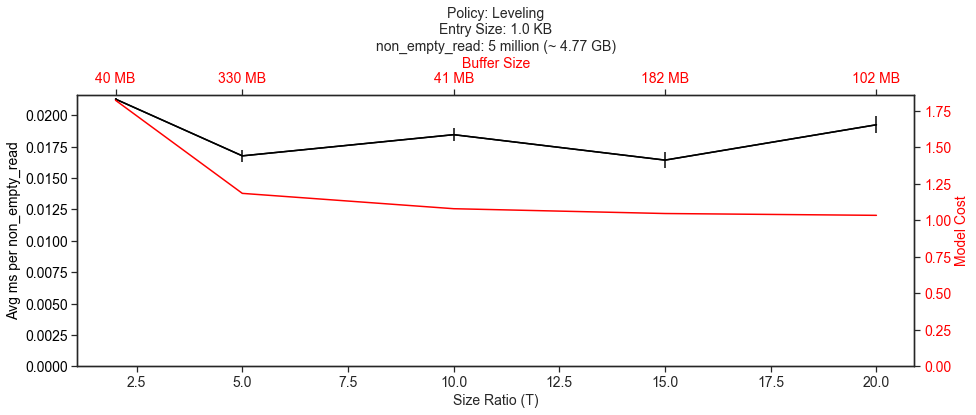

In [102]:
df = read_data('../../data/read_cost/2.csv')

set_style()
_ = plot_cost_ratio(df, operation='non_empty_read', num_runs=5)

# Empty Reads

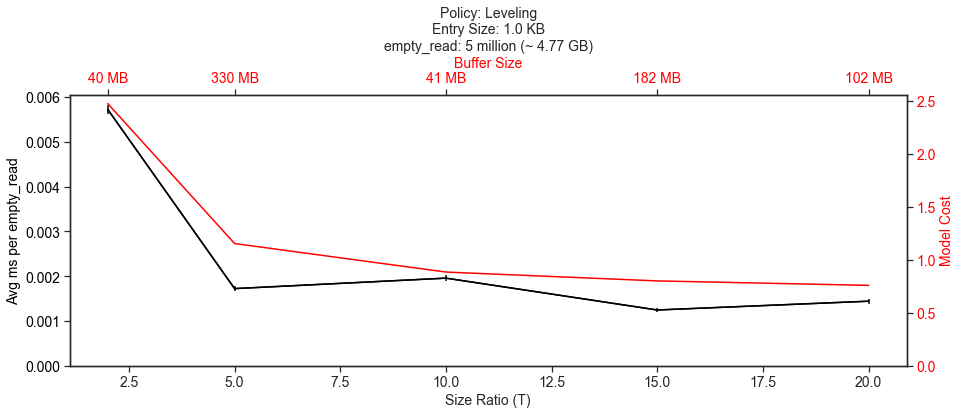

In [104]:
_ = plot_cost_ratio(df, 'empty_read', num_runs=5)